In [ ]:

import sys
sys.path.insert(0, '..')
import pennylane as qml
from qoop.core import ansatz, state
import pennylane.numpy as nps
import qiskit
import numpy as np
from qoop.hamiltonian import hamiltonian
from qiskit.circuit.library import UnitaryGate

num_qubits = 3
def dynamic(opt, num_layers, t):
    dev = qml.device("default.qubit")
    qc = qiskit.QuantumCircuit(num_qubits)

    h_opt = hamiltonian.XYZ_model(N = num_qubits, J = 0.5, u = 0, h = [0,0,0,0])
    U = state.time_dependent_u(4,h_opt, t)
    if not np.allclose(U @ U.conj().T, np.eye(U.shape[0])):
        raise ValueError("The resulting matrix U is not unitary.")

    unitary_gate = UnitaryGate(U)
    qc.append(unitary_gate, range(num_qubits))
    qcx = qiskit.transpile(qc, basis_gates=['h','s','cx','u','rx','ry','rz'], optimization_level=3)

    @qml.qnode(dev, diff_method="parameter-shift")
    def circuit2(thetas):
        j = 0
        for _ in range(0, num_layers):
            for i in range(0, num_qubits - 1):
                qml.CRY(thetas[j], wires=[i,i+1])
                j += 1
            qml.CRY(thetas[j], wires=[num_qubits - 1, 0])
            j += 1
            for i in range(0, num_qubits):
                qml.RZ(thetas[j], wires=i)
                qml.RX(thetas[j+1], wires=i)
                qml.RZ(thetas[j+2], wires=i)
                j += 3
        return qml.expval(qml.PauliZ(0))
        

    def cost_fn(thetas):
        return 1 - circuit2(thetas)

    thetas = nps.random.uniform(0, 2*nps.pi, 4 * num_qubits * num_layers)

    steps = 400
    costs = []
    grad_func = qml.grad(cost_fn)
    for n in range(steps):
        thetas, cost = opt.step_and_cost(cost_fn, thetas, grad_fn = grad_func)
        costs.append(cost)
    return costs

In [22]:
ts = np.linspace(0, 10, 41)
ts

array([ 0.  ,  0.25,  0.5 ,  0.75,  1.  ,  1.25,  1.5 ,  1.75,  2.  ,
        2.25,  2.5 ,  2.75,  3.  ,  3.25,  3.5 ,  3.75,  4.  ,  4.25,
        4.5 ,  4.75,  5.  ,  5.25,  5.5 ,  5.75,  6.  ,  6.25,  6.5 ,
        6.75,  7.  ,  7.25,  7.5 ,  7.75,  8.  ,  8.25,  8.5 ,  8.75,
        9.  ,  9.25,  9.5 ,  9.75, 10.  ])

In [ ]:
from qoop.core import optimizer_pennylane

optimizer_funcs = [qml.AdamOptimizer, 
             optimizer_pennylane.AdamWOptimizer,
             optimizer_pennylane.AMSGradOptimizer,
             optimizer_pennylane.NadamOptimizer,
             optimizer_pennylane.RAdamOptimizer,
             optimizer_pennylane.QHAdamOptimizer,
             optimizer_pennylane.AdamaxOptimizer]

costss = []
num_layers = 2
ts = np.linspace(0, 10, 41)
for optimizer_func in optimizer_funcs:
    for t in ts:
        print(optimizer_func.__name__)
        opt = optimizer_func(stepsize = 0.1)
        costs = dynamic(opt, num_layers, t)
        np.savetxt(f"../data/loss/lossdynamic_{num_qubits}qubit_{num_layers}layer_{optimizer_func.__name__}_t{t}.txt", costs)
        costss.append(costs)


AdamOptimizer
AdamWOptimizer
AMSGradOptimizer
NadamOptimizer
RAdamOptimizer
QHAdamOptimizer
AdamaxOptimizer


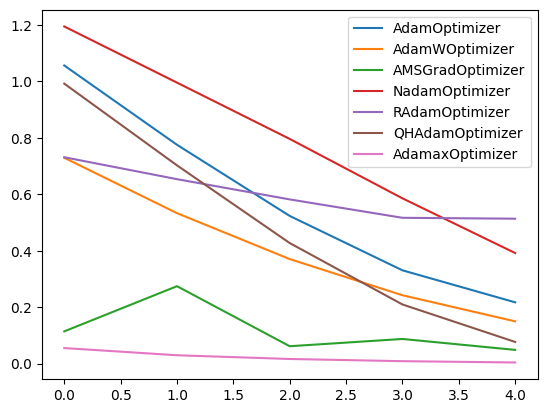

In [15]:
import matplotlib.pyplot as plt
for j, optimizer_func in enumerate(optimizer_funcs):
    costs = np.loadtxt(f"../data/loss/lossdynamic_{num_qubits}qubit_{num_layers}layer_{optimizer_func.__name__}.txt")
    plt.plot(costs[:50], label = optimizer_func.__name__)
plt.legend()